This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


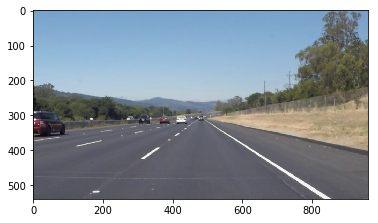

In [1]:
#importing some useful packages
import os
from os import listdir
from os.path import isfile, join

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from moviepy.editor import VideoFileClip
from IPython.display import HTML

import numpy as np
import cv2
import math

%matplotlib inline
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

def convert_hls(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
converted_image = np.copy(convert_hls(image))


In [2]:
# Read in the image and print out some stats
image = mpimg.imread('test.jpg')
print('This image is: ',type(image), 
         'with dimensions:', image.shape)

# Grab the x and y size and make a copy of the image
ysize = image.shape[0]
xsize = image.shape[1]
no_color_channels = image.shape[2]
print("ysize is: ",ysize)
print("xsize is: ",xsize)
print("Number of color channels: ",no_color_channels)
# Note: always make a copy rather than simply using "="
color_select = np.copy(image)


This image is:  <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
ysize is:  540
xsize is:  960
Number of color channels:  3


In [3]:
def load_image(image_path):
    return mpimg.imread(image_path)
#function returns a grayscale image(called gray_img or gray_image) that will feed gaussian_noise and canny functions
#during image processing 
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#Removes noise from our grayscaled_image by blurring it. It actually removes high frequency content (eg noise, edges) from the image.
#5 is a fairly standard value for kernel size at function call.
def gaussian_noise(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

def region_of_interest(img, vertices):
    #blacksout the image by converting the initial image to an array of all zeros because black is(0,0,0)
    mask = np.zeros_like(img)
    imshape = img.shape
    bottom_left = (115,imshape[0])
    top_left = (470,.60*imshape[0])
    bottom_right = (imshape[1]*.92,imshape[0])
    top_right = (490,imshape[0]*.60)
    vertices = np.array([[(bottom_left),(top_left),(top_right),(bottom_right)]], dtype=np.int32)
#     if len(img.shape) > 2:
#         channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
#         ignore_mask_color = (255,) * channel_count
#     else:
#         ignore_mask_color = (255,)

    #cv2.fillPoly(mask, vertices, ignore_mask_color)
    selected_region = cv2.fillPoly(mask, vertices,(255,255,255))
    #masked_image = cv2.bitwise_and(img, mask)
    masked_image = cv2.bitwise_and(img, selected_region)
    return masked_image

def draw_lines(img, lines, color=[255,0,0], thickness=10):
    right_slope = []
    left_slope = []
    left_b_value = []
    right_b_value = []

    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

            m = ((y2-y1)/(x2-x1)) # slope
            b = y1-m*x1
            if m < 0:
                left_slope.append(m)
                left_b_value.append(b)
            elif m > 0:
                right_slope.append(m)
                right_b_value.append(b)  
        # Get image shape and define y region of interest value(roi)
    imshape = img.shape
    y_max   = imshape[0] # lines initial point at bottom of image    
    y_min   = imshape[0]*0.60 # slightly lower than the middle 
    # Get the mean of all the line values
    avg_right_slope = mean(right_slope)
    avg_left_slope = mean(left_slope)
    avg_left_b_value = mean(left_b_value)
    avg_right_b_value = mean(right_b_value)
    # define average left and right lines
    #use average slopes to generate line using region of interest endpoints
    if avg_left_slope != 0:
        #converting float values to integers for cv2
        x1_left = int((y_max - avg_left_b_value)/avg_left_slope)
        y1_left = int(y_max)
        x2_left = int((y_min - avg_left_b_value)/avg_left_slope)
        y2_left = int(y_min)
        cv2.line(img, (x1_left,y1_left), (x2_left,y2_left), color, thickness) #avg Left Line
    if avg_right_slope != 0:
        x1_right = int((y_max - avg_right_b_value)/avg_right_slope) 
        y1_right = int(y_max)
        x2_right = int((y_min - avg_right_b_value)/avg_right_slope)
        y2_right = int(y_min)
        cv2.line(img, (x1_right, y1_right), (x2_right,y2_right), color, thickness) #avg Right Line  
        

        
    
def mean(list):
    """
    calculate mean of list
    """
    return float(sum(list)) / max(len(list), 1)
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold,
                            np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    #line_img = np.zeros((img.shape[0],img.shape[1],3), dtype=np.uint8)
    line_img = np.zeros(img.shape, dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

def weighted_img(img, initial_img, alpha=0.8, beta=1., gamma=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    `initial_img` should be the image before any processing.
    The result image is computed as follows:
    initial_img * alpha + img * beta + gamma
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, alpha, img, beta, gamma)

def get_files(dir_path):
    return [f for f in listdir(dir_path) if isfile(join(dir_path, f))]

def process_img(img):
    line_image = np.copy(img)
    gray_img = grayscale(img)
    blur_gray = gaussian_noise(gray_img, 5)
    edges = canny(blur_gray, 50, 150)

    imshape = img.shape
    ysize = imshape[0]
    xsize = imshape[1]
    #defining region of interest where I will search for lane lines
    bottom_left = (115,imshape[0])
    top_left = (470,.60*imshape[0])
    bottom_right = (imshape[1]*.92,imshape[0])
    top_right = (490,imshape[0]*.60)
    
    rho = 1  #distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 15     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 40 #minimum number of pixels making up a line
    max_line_gap = 30    # maximum gap in pixels between connectable line segments
                          
    vertices = np.array([[(bottom_left),(top_left),(top_right),(bottom_right)]], dtype=np.int32)

    masked_edges = region_of_interest(edges, vertices)
    lines = hough_lines (masked_edges, rho, theta, threshold, min_line_length, max_line_gap)

    #lines = hough_lines(masked_edges, 1, np.pi/180, 25, 10, 10)
#     final_img = weighted_img(lines, line_image)
#     
    zeros = np.zeros_like(lines)
    lines = np.dstack((lines, zeros, zeros))
    final_img = weighted_img(lines, line_image)
    return final_img


In [4]:
import os
files = os.listdir("test_images/")
for file in files:
    print(file)


.ipynb_checkpoints
solidWhiteCurve.jpg
solidWhiteRight.jpg
solidYellowCurve.jpg
solidYellowCurve2.jpg
solidYellowLeft.jpg
whiteCarLaneSwitch.jpg


processing solidWhiteCurve.jpg


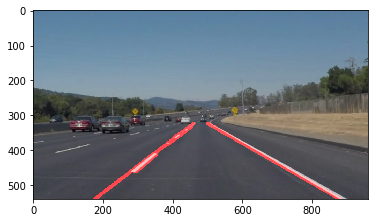

processing solidWhiteRight.jpg


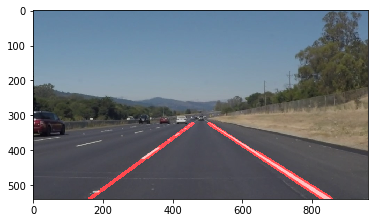

processing solidYellowCurve.jpg


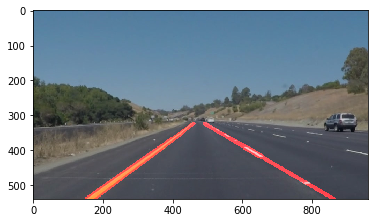

processing solidYellowCurve2.jpg


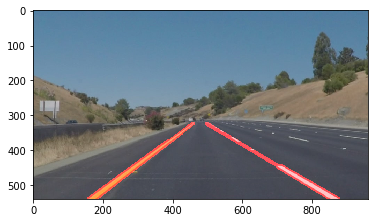

processing solidYellowLeft.jpg


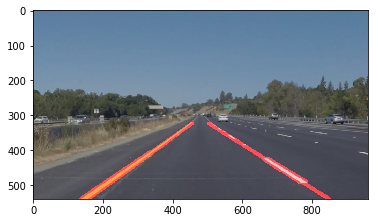

processing whiteCarLaneSwitch.jpg


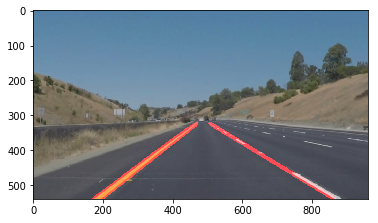

In [5]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

images = get_files('./test_images')

for name in images:

    if name.startswith("."): continue

    print("processing", name)

    img = load_image('{}/{}'.format('./test_images', name))

    img = process_img(img)
    mpimg.imsave("output_images/"+file[:-4]+"processed.png", img)
   

    plt.imshow(img)
    plt.show()

In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def process_images(name, img):
    """
    # 1: grayscale the image
    # 2: define edges
    # 3: Hough transform
    # 4: Apply ROI
    """
    final_img = processs_img(img)


def process_video(name):
    """ ok """
    _output = 'final_'+name
    clip1 = VideoFileClip(name)
    white_clip = clip1.fl_image(process_img) #NOTE: this function expects color images!!
    white_clip.write_videofile(_output, audio=False)

In [7]:
# white_output = 'white.mp4'
# clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
# white_clip = clip1.fl_image(process_img) #NOTE: this function expects color images!!
# %time white_clip.write_videofile(white_output, audio=False)
white_output = 'output_videos/white.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_img) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output_videos/white.mp4
[MoviePy] Writing video output_videos/white.mp4


100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:02<00:00, 74.88it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/white.mp4 

Wall time: 3.26 s


In [8]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [9]:
# yellow_output = 'yellow.mp4'
# clip2 = VideoFileClip('./test_videos/solidYellowLeft.mp4')
# yellow_clip = clip2.fl_image(process_img)
# %time yellow_clip.write_videofile(yellow_output, audio=False)
yellow_output = 'output_videos/yellow.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_img)
%time yellow_clip.write_videofile(yellow_output, audio=False)


[MoviePy] >>>> Building video output_videos/yellow.mp4
[MoviePy] Writing video output_videos/yellow.mp4


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [00:08<00:00, 75.98it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/yellow.mp4 

Wall time: 9.27 s


In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))